# setting

## path

In [17]:
import sys, os
home_path = os.path.expanduser("~")
sys.path.append(home_path + '/Desktop/Credit_Comp/py/models/')
sys.path.append(home_path + '/Desktop/Credit_Comp/py/')
sys.path.append(home_path + '/.pyenv/versions/3.6.5/lib/python3.6/site-packages')

## module

使用するモジュールをimport

In [93]:
import numpy as np # linear algebra
import pandas as pd # data processing
import pandas_profiling as pdp
import base # basic processed code
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [129]:
# moduleの再読み込み(作業中に更新した内容をここで更新できる)
import importlib
importlib.reload(base)

<module 'base' from '/Users/takuto/Desktop/Credit_Comp/py/base.py'>

In [130]:
# for instance
Process = base.Process()
Applicate = base.Applicate()

## read data

In [72]:
train, test = Process.read_data1()

27000 observations and 24 features in train set.
3000 observations and 23 features in test set.


# eda

In [48]:
# 欠損値の確認
Applicate.missing_value(train)

,y,X11,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X12,X23,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,id
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# 簡単なレポート作成
profile = pdp.ProfileReport(train)
file_name = home_path + '/Desktop/Credit_Comp/output/report/train_data_profile.html'
profile.to_file(outputfile = file_name)

# Detail

## クレジット金額と支払い履行の関係性

少額を踏み倒している?

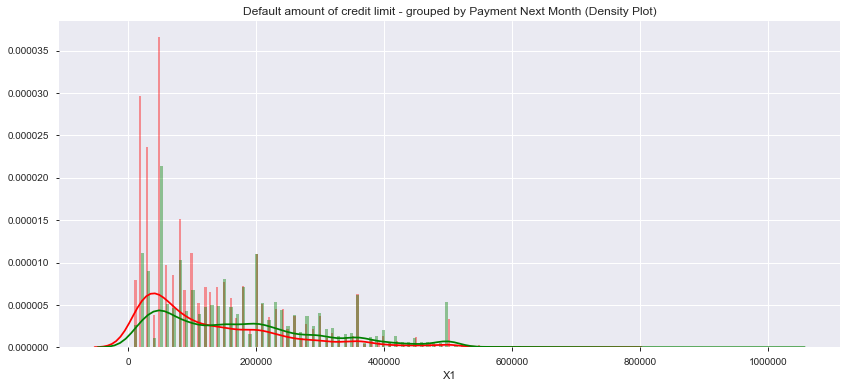

In [97]:
class_0 = train.loc[train['y'] == 0]['X1']
class_1 = train.loc[train['y'] == 1]['X1']
plt.figure(figsize = (14,6))
plt.title('Default amount of credit limit - grouped by Payment Next Month (Density Plot)')
sns.set_color_codes("pastel")
sns.distplot(class_1,kde=True,bins=200, color="red")
sns.distplot(class_0,kde=True,bins=200, color="green")
plt.show()

## 年齢と支払い履行の関係性

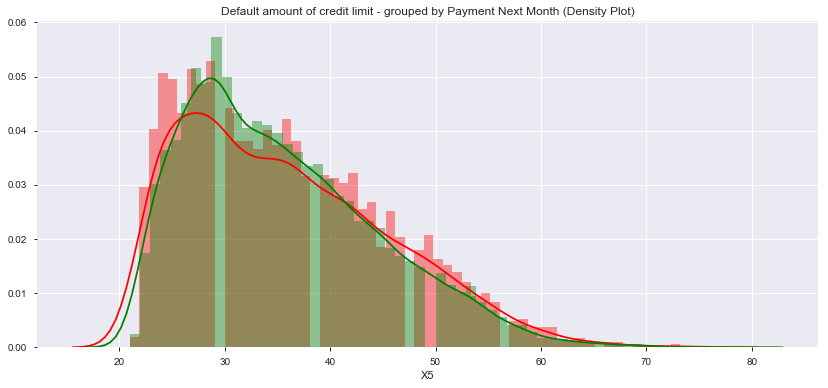

In [108]:
class_0 = train.loc[train['y'] == 0]['X5']
class_1 = train.loc[train['y'] == 1]['X5']
plt.figure(figsize = (14,6))
plt.title('Default amount of credit limit - grouped by Payment Next Month (Density Plot)')
sns.set_color_codes("pastel")
sns.distplot(class_1,kde=True,bins=60, color="red")
sns.distplot(class_0,kde=True,bins=60, color="green")
plt.show()

## カテゴリカル変数のクロス集計 

In [111]:
print("性別（1=男性, 2=女性)")
print(pd.crosstab(index=train["X2"],columns=train["y"]))
print("教育（1=大学院, 2=大学, 3=高校, 0,4,5,6=その他）")
print(pd.crosstab(index=train["X3"],columns=train["y"]))
print("婚姻状況（1=既婚, 2=単身, 3=離婚, 0=その他）")
print(pd.crosstab(index=train["X4"],columns=train["y"]))

性別（1=男性, 2=女性)
y       0     1
X2             
1    8126  2591
2   12880  3403
教育（1=大学院, 2=大学, 3=高校, 0,4,5,6=その他）
y      0     1
X3            
0     12     0
1   7671  1834
2   9633  3013
3   3317  1117
4    105     6
5    226    18
6     42     6
婚姻状況（1=既婚, 2=単身, 3=離婚, 0=その他）
y       0     1
X4             
0      42     4
1    9402  2904
2   11348  3010
3     214    76


# Feature Correlation

## 支払い記録の相関

1ヶ月ごとに遅れていくので, 相関が生まれやすい

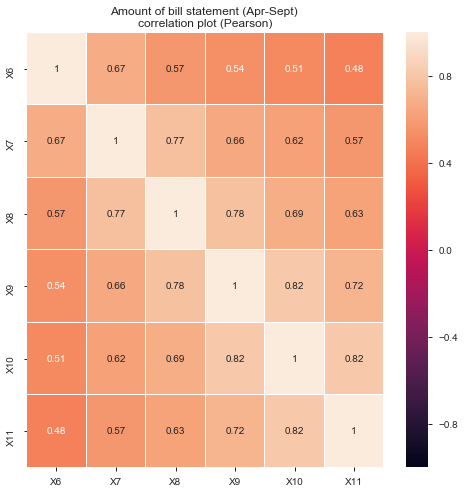

In [117]:
var = ["X6","X7","X8","X9","X10","X11"]
plt.figure(figsize = (8,8))
plt.title('Amount of bill statement (Apr-Sept) \ncorrelation plot (Pearson)')
corr = train[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1,annot=True)
plt.show()

## 請求明細書の相関

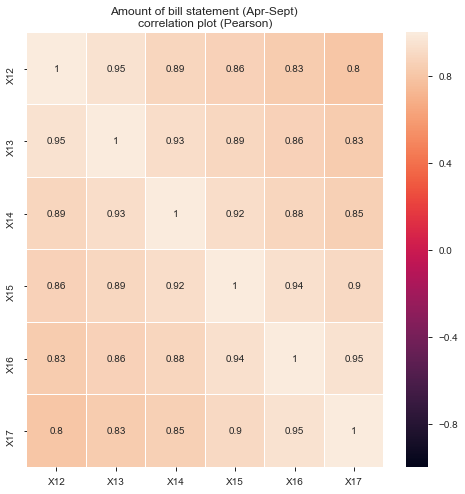

In [118]:
var = ["X12","X13","X14","X15","X16","X17"]
plt.figure(figsize = (8,8))
plt.title('Amount of bill statement (Apr-Sept) \ncorrelation plot (Pearson)')
corr = train[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1,annot=True)
plt.show()

# Simple model

## Decition tree

In [131]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
# execute model
clf = DecisionTreeClassifier(max_depth = 3)
clf = clf.fit(train.drop("y",axis=1), train["y"])
# predict value
predict = clf.predict(test)
predict
# sample submit
Process.submit(predict,tech="simple_decision_tree")

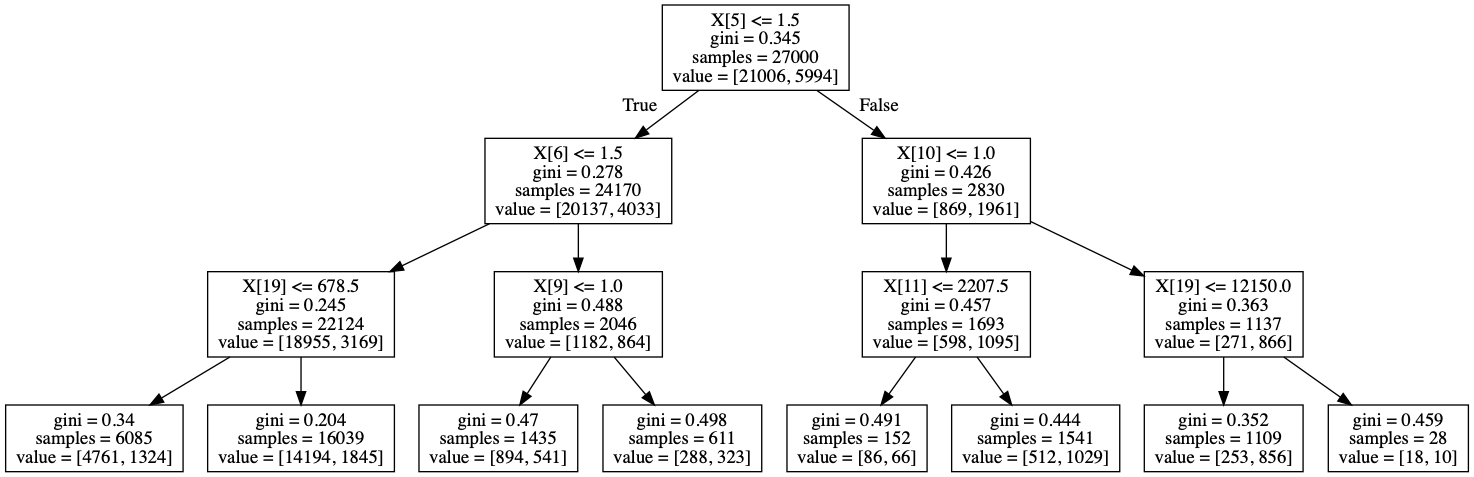

In [127]:
# treeの可視化
import pydotplus 
from IPython.display import Image
from sklearn.externals.six import StringIO
dot_data = StringIO()
export_graphviz(clf,out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
# pdfに保存
Image(graph.create_png())